**Table of contents**<a id='toc0_'></a>    
- 1. [Data preparation](#toc1_)    
  - 1.1. [Tokenize sentence and aspect BIO encoding class](#toc1_1_)    
  - 1.2. [Load data](#toc1_2_)    
  - 1.3. [Inspect tagging issues](#toc1_3_)    
- 2. [EDA](#toc2_)    
  - 2.1. [Transform "conflict" aspect to "negative"](#toc2_1_)    
- 3. [BERT](#toc3_)    
  - 3.1. [Convert df to HuggingFace datasets](#toc3_1_)    
  - 3.2. [Define model](#toc3_2_)    
    - 3.2.1. [Define tokenizer](#toc3_2_1_)    
    - 3.2.2. [Define token classification model](#toc3_2_2_)    
  - 3.3. [Data preparation](#toc3_3_)    
  - 3.4. [Performance metrics](#toc3_4_)    
  - 3.5. [Training](#toc3_5_)    
    - 3.5.1. [Define trainer](#toc3_5_1_)    
    - 3.5.2. [Training results](#toc3_5_2_)    
  - 3.6. [Error analysis](#toc3_6_)    
    - 3.6.1. [Model performance](#toc3_6_1_)    
    - 3.6.2. [Group by word token](#toc3_6_2_)    
    - 3.6.3. [Group by Tag ID](#toc3_6_3_)    
- 4. [Save model](#toc4_)    
- 5. [Load saved model](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os 
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0' # this setting is needed to run NN on my Mac

import re
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from highlight_text import HighlightText, ax_text, fig_text


from nltk.tokenize import TreebankWordTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from seqeval.metrics import f1_score, classification_report

# pip install torch==2.2.0 torchtext --index-url https://download.pytorch.org/whl/test/cpu

# 1. <a id='toc1_'></a>[Data preparation](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Tokenize sentence and aspect BIO encoding class](#toc0_)

In [2]:
class SentenceToken:
  '''
    SentenceToken

  '''
  def __init__(self, sentence, aspect_type=None, aspects=None, sentence_id=None):
    
    if sentence_id is not None:
      print(sentence_id)

    self.sentence_id = sentence_id
    self.sentence = sentence.replace(u"\u00A0", " ").replace(u'\xa0',' ') # replace unicode space character
                            
    self.aspect_bio_tags = None
    self.unified_aspect_bio_tags = None
    self.token_span = None
    self.space_pre_token = None

    # Tokenize sentence
    self.__tokenize_sentence(self.sentence)

    if aspect_type == 'dict':
      self.set_aspect_tagging_from_dict(aspects)
    elif aspect_type == 'bio':
      self.set_aspect_bio_tags(aspects)
    elif aspect_type == 'unified bio':
      self.set_aspect_unified_bio_tags(aspects)
  
  def __tokenize_sentence(self, sentence):
    token_span = list(TreebankWordTokenizer().span_tokenize(sentence))
    new_token_span = token_span #[] # if want to break down word followed by special character using the commented code
    
    # for k in token_span:
    #   token_start = k[0]
    #   token_end = k[1]

    #   token = sentence[token_start:token_end]
    #   sub_tokens = re.split(r'([^\w,\d])', token)
      
    #   sub_token_start = token_start
    #   for sub_token in sub_tokens:
    #     if len(sub_token) != 0:
    #       sub_token_end = sub_token_start + len(sub_token)
    #       new_token_span.append((sub_token_start, sub_token_end))
    #       sub_token_start = sub_token_end
    
    self.token_span = new_token_span
    self.space_pre_token = [True if sentence[k[0]-1:k[0]] == ' ' else False for i,k in enumerate(new_token_span)]

  def set_aspect_tagging_from_dict(self, aspects):
    polarity_map = {'positive':'POS'
              ,'negative': 'NEG'
              ,'conflict': 'CON'
              ,'neutral': 'NEU'}
    
    bio_tags = ['O'] * len(self.token_span)
    unified_bio_tags = bio_tags

    for x in aspects:
      if x['term'] != '':
        aspect_from = int(x['from'])
        aspect_to = int(x['to'])
        polarity = '-' + polarity_map[x['polarity']]

        # aspect_token_ids =  [i for i, v in enumerate(self.token_span) if (v[0] >= aspect_from) & (v[1] <= aspect_to)]
        # if aspect_token_ids != []:
        #   aspect_from_index = min(aspect_token_ids)
        #   aspect_to_index = max(aspect_token_ids)
        #   aspect_from = int(x['from'])
        #   aspect_length = aspect_to_index - aspect_from_index
        #   bio_tags = bio_tags[:aspect_from_index] + ['B'] + ['I'] * (aspect_length) + bio_tags[aspect_to_index+1:]
        #   unified_bio_tags = unified_bio_tags[:aspect_from_index] + ['B' + polarity] + ['I'+ polarity] * (aspect_length) + unified_bio_tags[aspect_to_index+1:]
        
        aspect_from_index = [i for i, v in enumerate(self.token_span) if (v[0] <= aspect_from) & (v[1] >= aspect_from)][0]
        aspect_to_index = [i for i, v in enumerate(self.token_span) if (v[0] <= aspect_to) & (v[1] >= aspect_to)][0]
      
        aspect_length = aspect_to_index - aspect_from_index
        bio_tags = bio_tags[:aspect_from_index] + ['B'] + ['I'] * (aspect_length) + bio_tags[aspect_to_index+1:]
        unified_bio_tags = unified_bio_tags[:aspect_from_index] + ['B' + polarity] + ['I'+ polarity] * (aspect_length) + unified_bio_tags[aspect_to_index+1:]
        

    self.set_aspect_bio_tags(bio_tags)
    self.set_aspect_unified_bio_tags(unified_bio_tags)

  def rebuild_sentence_from_token(self):
    return ''.join([(' ' if self.space_pre_token[i] else '') + self.sentence[k[0]:k[1]] for i, k in enumerate(self.token_span)])
  
  def get_sentence_token_with_aspect_bio_tag(self, unified_bio_tag=False):
    if (unified_bio_tag == False) & (self.aspect_bio_tags is None):
      raise Exception('No BIO tags provided. Use "SentenceToken.set_aspect_bio_tags()" method to add bio_tags')
    elif (unified_bio_tag == True) & (self.aspect_unified_bio_tags is None):
      raise Exception('No Unified BIO tags provided. Use "SentenceToken.set_aspect_unified_bio_tags()" method to add unified_bio_tags')
    else:
      return [(self.sentence[k[0]:k[1]], self.aspect_unified_bio_tags[i] if unified_bio_tag else self.aspect_bio_tags[i]) for i, k in enumerate(self.token_span)]

  def set_aspect_bio_tags(self, aspect_bio_tags):
    self.aspect_bio_tags = aspect_bio_tags
    self.aspect_unified_bio_tags = aspect_bio_tags

  def set_aspect_unified_bio_tags(self, aspect_unified_bio_tags):
    self.aspect_unified_bio_tags = aspect_unified_bio_tags
    self.aspect_bio_tags = [k[0:1] for k in aspect_unified_bio_tags]

  def get_tokens(self):
    '''
    get_tokens()
    Return an array of sentence word tokens
    '''
    return [self.sentence[k[0]:k[1]] for k in self.token_span]
  
  def check_rebuild_sentence_from_token(self):
    '''
    check_rebuild_sentence_from_token()

    This is a test / debugger function.
    This help validating if we have computed the sentence to token properly and whether we can re-compute the exact sentence from information stored.
    '''
    return re.sub(r'\s+', ' ',self.sentence.strip()) == self.rebuild_sentence_from_token().strip()
  
  def check_rebuild_aspect_terms(self, aspect_dict):
    '''
    check_rebuild_aspect_terms(aspect_dict)

    This is a test / debugger fucntion. 
    This help validate if we have compute the correct aspect terms as given by the aspect dict

    INPUT:
    aspect dict: array of aspect dictionaries in the following format
      [{'term': 'storage', 
       'polarity': 'positive', 
       'from': '14', 
       'to': '21'}]
    '''
    aspect_dict = sorted(aspect_dict, key=lambda d: int(d['from']))
    aspect_input = [k['term'].replace(u"\u00A0", " ").replace(u'\xa0',' ') for k in aspect_dict if k['term'] != '' ]
    aspect_computed = []
    aspect = ''
    
    for i,k in enumerate(self.aspect_bio_tags):
      token = self.sentence[self.token_span[i][0]:self.token_span[i][1]]
      
      if k == 'B':
        if (self.aspect_bio_tags[i-1] == 'B' if i > 0 else False):
          aspect_computed.append(aspect)
        aspect = token
      elif k == 'I':
        aspect += ' ' * ((self.token_span[i][0] -  self.token_span[i-1][1]) if i > 0 else 0) + token
      
      if (aspect != '') & ((k == 'O') or (i == (len(self.aspect_bio_tags) - 1))):
          aspect_computed.append(aspect)
          aspect = ''

    return [aspect_input == aspect_computed, aspect_input, aspect_computed]

  def __str__(self):
    return self.rebuild_sentence_from_token()


## 1.2. <a id='toc1_2_'></a>[Load data](#toc0_)

In [3]:
def reload_Data():
  df_train = pd.read_json('data/laptop/train.json')
  # First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.
  # We have removed 12 duplicated records in our training dataset
  df_train.drop_duplicates(subset='text', inplace=True)
  print('df_train shape: ', df_train.shape)

  df_val = pd.read_json('data/laptop/validate.json') # This will only be used for the very last step to evaluate how well the model is, but is input now for validating the BIO tagging to ensure the function works properly
  print('df_val shape: ', df_val.shape)

  df_train['sentence_token'] = df_train.apply(lambda x: SentenceToken(x['text'], 'dict', x['aspects']), axis=1)
  df_train['sentence_check'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_sentence_from_token(), axis=1)
  df_train['aspect_check'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects']), axis=1)
  df_train['aspect_check_TF'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects'])[0], axis=1)
  df_train['tokens'] = df_train.apply(lambda x: x['sentence_token'].get_tokens(), axis=1)
  df_train['tags'] = df_train.apply(lambda x: x['sentence_token'].aspect_unified_bio_tags, axis=1)

  df_val['sentence_token'] = df_val.apply(lambda x: SentenceToken(x['text'], 'dict', x['aspects']), axis=1)
  df_val['sentence_check'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_sentence_from_token(), axis=1)
  df_val['aspect_check'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects']), axis=1)
  df_val['aspect_check_TF'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects'])[0], axis=1)
  df_val['tokens'] = df_val.apply(lambda x: x['sentence_token'].get_tokens(), axis=1)
  df_val['tags'] = df_val.apply(lambda x: x['sentence_token'].aspect_unified_bio_tags, axis=1)
  return df_train, df_val

In [4]:
df_train, df_test = reload_Data()
print('# of df_train records having tokenizing issues: ', len(df_train[df_train['sentence_check']==False]))
print('# of df_train records having aspect bio tagging issues: ', len(df_train[df_train['aspect_check_TF']==False]))
print('# of df_test records having tokenizing issues: ', len(df_test[df_test['sentence_check']==False]))
print('# of df_test records having aspect bio tagging issues: ', len(df_test[df_test['aspect_check_TF']==False]))

df_train shape:  (3036, 3)
df_val shape:  (800, 3)
# of df_train records having tokenizing issues:  0
# of df_train records having aspect bio tagging issues:  36
# of df_test records having tokenizing issues:  0
# of df_test records having aspect bio tagging issues:  9


## 1.3. <a id='toc1_3_'></a>[Inspect tagging issues](#toc0_)

In [5]:
print(df_train[df_train['aspect_check_TF']==False].index)

Index([ 125,  140,  220,  293,  374,  375,  431,  612,  656,  834,  922,  924,
        953,  999, 1031, 1374, 1456, 1502, 1631, 1716, 1936, 1958, 2113, 2160,
       2244, 2392, 2502, 2533, 2587, 2606, 2783, 2831, 2842, 2876, 2930, 2940],
      dtype='int64')


In [6]:
num = 2606

print(df_train.loc[num]['aspects'])
print(df_train.loc[num]['text'])
print(df_train.loc[num]['aspect_check'])
print(df_train.loc[num]['tokens'])

[{'term': 'delivery service', 'polarity': 'negative', 'from': '59', 'to': '75'}]
After way too many times sending the thing in for repairs (delivery service was slow, and without the laptop I had no access to the internet, and thus no way of tracking it to find out when I might hope to see my computer again), it finally kicked the bucket after just over 2 years.
[False, ['delivery service'], ['(delivery service']]
['After', 'way', 'too', 'many', 'times', 'sending', 'the', 'thing', 'in', 'for', 'repairs', '(', 'delivery', 'service', 'was', 'slow', ',', 'and', 'without', 'the', 'laptop', 'I', 'had', 'no', 'access', 'to', 'the', 'internet', ',', 'and', 'thus', 'no', 'way', 'of', 'tracking', 'it', 'to', 'find', 'out', 'when', 'I', 'might', 'hope', 'to', 'see', 'my', 'computer', 'again', ')', ',', 'it', 'finally', 'kicked', 'the', 'bucket', 'after', 'just', 'over', '2', 'years', '.']


Most of the tagging issues due to word that are not separated properly from special characters/ punctuations. The issue is unavoidable in practice as reviews may not adherent to perfect grammar.

I have tried to fix this issues to have 100% accuracy with further token breakdown to match the specified aspect tokens, however, this can break some of the standard logics for word tokenizer and further modelling. 

Therefore, I decided to include a whole token where the aspect may start or end, even if the index is in the middle of token, which may results with aspect tokens that could include extra characters than planned. This is the risk we will accept for this approach, and we can perform a cleaning process to remove these extra characters during implementation with actual use cases.

# 2. <a id='toc2_'></a>[EDA](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Transform "conflict" aspect to "negative"](#toc0_)

# 3. <a id='toc3_'></a>[BERT](#toc0_)

In [7]:
import datasets
from datasets import Dataset, DatasetDict, Features, Sequence, Value, ClassLabel

import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy

from transformers import AutoConfig, DistilBertConfig, AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.distilbert.modeling_distilbert import DistilBertModel
from transformers.models.distilbert.modeling_distilbert import DistilBertPreTrainedModel

device = torch.device('mps') # This is required for Mac

/Users/tina.vu/work/fun/sentilens_env_wipp/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/tina.vu/work/fun/sentilens_env_wipp/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-01-28 11:52:12.309299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3.1. <a id='toc3_1_'></a>[Convert df to HuggingFace datasets](#toc0_)

Convert aspect tag to id

In [8]:
# Generate list of unique aspect tags
tags = list(set(sum(df_train['tags'],[])))
tags.sort()
tag2idx = {k:i for i,k in enumerate(tags)}

# Convert aspect tag text to ids
df_train['tags_idx'] = df_train['tags'].apply(lambda x: [tag2idx[k] for k in x])
df_test['tags_idx'] = df_test['tags'].apply(lambda x: [tag2idx[k] for k in x])

Convert pandas to HuggingFace datasets

In [9]:
# Split train into train & validation set
df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=42,)

# Define dataset features
features = Features({'tokens': Sequence(Value(dtype='string', id=None)),
                    'tags_idx': Sequence(ClassLabel(names=tags))
                    })

tds = Dataset.from_pandas(df_train[['tokens','tags_idx']], features=features, preserve_index=False)
vds = Dataset.from_pandas(df_val[['tokens','tags_idx']], features=features,  preserve_index=False)
tsds = Dataset.from_pandas(df_test[['tokens','tags_idx']], features=features, preserve_index=False)

ds = DatasetDict()

ds['train'] = tds
ds['validation'] = vds
ds['test'] = tsds

print(ds)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags_idx'],
        num_rows: 2125
    })
    validation: Dataset({
        features: ['tokens', 'tags_idx'],
        num_rows: 911
    })
    test: Dataset({
        features: ['tokens', 'tags_idx'],
        num_rows: 800
    })
})


Check for total counts per aspect type in each data split

In [10]:
# Convert aspect idx to aspect aspect text
def create_tag_names(batch):
    return {"tags": [ds["train"].features["tags_idx"].feature.int2str(idx) for idx in batch["tags_idx"]]}

ds = ds.map(create_tag_names)

Map:   0%|          | 0/2125 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [11]:
# Perform aspect type counts per each dataset split
split2freqs = defaultdict(Counter)
for split, dataset in ds.items():
    for row in dataset["tags"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
                
pd.DataFrame.from_dict(split2freqs, orient="index")

,NEG,POS,NEU,CON
train,552,675,304,30
validation,310,312,157,15
test,128,340,169,16


## 3.2. <a id='toc3_2_'></a>[Define model](#toc0_)

In [12]:
distilbert_model_name = "distilbert-base-uncased"

### 3.2.1. <a id='toc3_2_1_'></a>[Define tokenizer](#toc0_)

In [13]:
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### 3.2.2. <a id='toc3_2_2_'></a>[Define token classification model](#toc0_)

In [14]:
tags = ds['train'].features['tags_idx'].feature

index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
tags

ClassLabel(names=['B-CON', 'B-NEG', 'B-NEU', 'B-POS', 'I-CON', 'I-NEG', 'I-NEU', 'I-POS', 'O'], id=None)

In [15]:
distilbert_config = AutoConfig.from_pretrained(distilbert_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [42]:
class DistilBertForABSA(DistilBertPreTrainedModel):
    config_class = DistilBertConfig

    def __init__(self, config):
        super().__init__(config)
        # Roberta body
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config)#, add_pooling_layer=False)

        # Classification head
        self.dropout = nn.Dropout(config.dropout)#hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Load and initialize weights from pretrained
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        
        # Use model body to get encoder representations
        outputs = self.distilbert(input_ids, attention_mask=attention_mask,
                            #    token_type_ids=token_type_ids,
                                 **kwargs)
        
        # Apply classifier to encoder representation (model head)
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)
     

## 3.3. <a id='toc3_3_'></a>[Data preparation](#toc0_)

In [43]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = distilbert_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["tags_idx"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [44]:
# def tokenize_and_align_labels(examples):
#     tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
#                                       is_split_into_words=True)
#     labels = []
#     for idx, label in enumerate(examples["tags_idx"]):
#         word_ids = tokenized_inputs.word_ids(batch_index=idx)
#         previous_word_idx = None
#         label_ids = []
#         for word_idx in word_ids:
#             if word_idx is None or word_idx == previous_word_idx:
#                 label_ids.append(-100)
#             else:
#                 label_ids.append(tag2index[label[word_idx]])
#             previous_word_idx = word_idx
#         labels.append(label_ids)
#     tokenized_inputs["labels"] = labels
#     return tokenized_inputs

In [45]:
def encode_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['tags_idx', 'tokens','tags']
                      )

In [46]:
# hide_output
ds_encoded = encode_dataset(ds)

Map:   0%|          | 0/2125 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

## 3.4. <a id='toc3_4_'></a>[Performance metrics](#toc0_)

In [47]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                index2tag = distilbert_config.id2label.copy()
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [48]:
# Define performance metrics
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred, average='macro')}

## 3.5. <a id='toc3_5_'></a>[Training](#toc0_)

### 3.5.1. <a id='toc3_5_1_'></a>[Define trainer](#toc0_)

In [49]:
# Define training arguments
num_epochs = 6
batch_size = 24
logging_steps = len(ds["train"]) // batch_size
model_name = f"{distilbert_model_name}-absa"

training_args = TrainingArguments(
    output_dir="model/" + model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=False)

# Define data collator for data batching 
data_collator = DataCollatorForTokenClassification(distilbert_tokenizer)
     
# Model init
def model_init():
    return (DistilBertForABSA
            .from_pretrained(distilbert_model_name, config=distilbert_config)
            .to(device))
     
trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=ds_encoded["train"],
                  eval_dataset=ds_encoded["validation"], 
                  tokenizer=distilbert_tokenizer)

In [50]:
trainer.train()

  0%|          | 0/534 [00:00<?, ?it/s]

{'loss': 0.2948, 'learning_rate': 4.176029962546817e-05, 'epoch': 0.99}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.1900884360074997, 'eval_f1': 0.21300712248953843, 'eval_runtime': 7.9668, 'eval_samples_per_second': 114.35, 'eval_steps_per_second': 4.77, 'epoch': 1.0}
{'loss': 0.1201, 'learning_rate': 3.352059925093633e-05, 'epoch': 1.98}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.16075395047664642, 'eval_f1': 0.2784990470017208, 'eval_runtime': 6.2083, 'eval_samples_per_second': 146.739, 'eval_steps_per_second': 6.121, 'epoch': 2.0}
{'loss': 0.0758, 'learning_rate': 2.5280898876404497e-05, 'epoch': 2.97}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.1632189303636551, 'eval_f1': 0.32174890097847714, 'eval_runtime': 5.5685, 'eval_samples_per_second': 163.599, 'eval_steps_per_second': 6.824, 'epoch': 3.0}
{'loss': 0.0463, 'learning_rate': 1.704119850187266e-05, 'epoch': 3.96}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.17591725289821625, 'eval_f1': 0.3663856555300663, 'eval_runtime': 7.8125, 'eval_samples_per_second': 116.607, 'eval_steps_per_second': 4.864, 'epoch': 4.0}
{'loss': 0.0327, 'learning_rate': 8.801498127340826e-06, 'epoch': 4.94}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.1830274760723114, 'eval_f1': 0.3780763652519378, 'eval_runtime': 15.2722, 'eval_samples_per_second': 59.651, 'eval_steps_per_second': 2.488, 'epoch': 5.0}
{'loss': 0.0243, 'learning_rate': 5.617977528089887e-07, 'epoch': 5.93}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.18804579973220825, 'eval_f1': 0.3785343138700393, 'eval_runtime': 15.7251, 'eval_samples_per_second': 57.933, 'eval_steps_per_second': 2.417, 'epoch': 6.0}
{'train_runtime': 1013.24, 'train_samples_per_second': 12.583, 'train_steps_per_second': 0.527, 'train_loss': 0.09816785619946455, 'epoch': 6.0}


TrainOutput(global_step=534, training_loss=0.09816785619946455, metrics={'train_runtime': 1013.24, 'train_samples_per_second': 12.583, 'train_steps_per_second': 0.527, 'train_loss': 0.09816785619946455, 'epoch': 6.0})

### 3.5.2. <a id='toc3_5_2_'></a>[Training results](#toc0_)

In [51]:
# https://huggingface.co/tnatvu/xlm-roberta-base-finetuned-panx-de/commit/392fb1439a34c700ee40c2b53da7b342f86aea5e
# CommitInfo(commit_url='https://huggingface.co/tnatvu/xlm-roberta-base-absa/commit/287181a14c225d7508e274c215c266865d0fe071', commit_message='Training completed!', commit_description='', oid='287181a14c225d7508e274c215c266865d0fe071', pr_url=None, pr_revision=None, pr_num=None)

df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss','eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", 'eval_f1':'F1'})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2948,0.190088,0.213007
2,2,0.1201,0.160754,0.278499
4,3,0.0758,0.163219,0.321749
6,4,0.0463,0.175917,0.366386
8,5,0.0327,0.183027,0.378076
10,6,0.0243,0.188046,0.378534


In [ ]:
# pip install torch==2.3.0.dev20240121 # this does not work

# pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu # run this in CLI before running the notebook

# import torch
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")

## 3.6. <a id='toc3_6_'></a>[Error analysis](#toc0_)

In [52]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)

        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, tags.num_classes), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}
     

In [53]:
validation_set = ds_encoded["validation"]
validation_set = validation_set.map(forward_pass_with_label, batched=True, batch_size=32)
df_validation = validation_set.to_pandas()

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

In [54]:
index2tag = trainer.model.config.id2label.copy()
index2tag[-100] = "IGN"
df_validation["input_tokens"] = df_validation["input_ids"].apply(
    lambda x: distilbert_tokenizer.convert_ids_to_tokens(x))
df_validation["predicted_label"] = df_validation["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df_validation["labels"] = df_validation["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df_validation['loss'] = df_validation.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df_validation['predicted_label'] = df_validation.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

df_tokens = df_validation.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
# df_tokens.head(7)

### 3.6.1. <a id='toc3_6_1_'></a>[Model performance](#toc0_)

In [55]:

df_validation_metrics = df_validation.copy()

In [56]:
num =800
print(df_validation_metrics.iloc[num]['input_tokens'])
print(df_validation_metrics.iloc[num]['labels'])
print(df_validation_metrics.iloc[num]['predicted_label'])
print(len(df_validation_metrics.iloc[num]['input_tokens']))
print(len(df_validation_metrics.iloc[num]['labels']))
print(len(df_validation_metrics.iloc[num]['predicted_label']))

['[CLS]', 'the', 'processor', 'went', 'on', 'me', ',', 'the', 'fan', 'went', 'and', 'the', 'mother', '##board', 'went', '.', '[SEP]']
['IGN', 'O', 'B-NEG', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'O', 'O', 'O', 'B-NEG', 'IGN', 'O', 'O', 'IGN']
['O', 'O', 'B-NEG', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'O', 'O', 'O', 'B-NEG', 'I-NEG', 'O', 'O', 'O']
17
17
17


In [57]:
df_validation_metrics['predicted_label'] = df_validation_metrics.apply(lambda x: [x['predicted_label'][i] for i,k in enumerate(x['labels']) if k != 'IGN' ], axis=1)
df_validation_metrics['labels'] = df_validation_metrics.apply(lambda x: [k for i,k in enumerate(x['labels']) if k != 'IGN' ], axis=1)


num =800
print(df_validation_metrics.iloc[num]['input_tokens'])
print(df_validation_metrics.iloc[num]['labels'])
print(df_validation_metrics.iloc[num]['predicted_label'])
print(len(df_validation_metrics.iloc[num]['input_tokens']))
print(len(df_validation_metrics.iloc[num]['labels']))
print(len(df_validation_metrics.iloc[num]['predicted_label']))

['[CLS]', 'the', 'processor', 'went', 'on', 'me', ',', 'the', 'fan', 'went', 'and', 'the', 'mother', '##board', 'went', '.', '[SEP]']
['O', 'B-NEG', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'O', 'O', 'O', 'B-NEG', 'O', 'O']
['O', 'B-NEG', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'O', 'O', 'O', 'B-NEG', 'O', 'O']
17
14
14


In [58]:
print(classification_report(df_validation_metrics['labels'], df_validation_metrics['predicted_label']))

/Users/tina.vu/work/fun/sentilens_env_wipp/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         CON       0.00      0.00      0.00        15
         NEG       0.54      0.55      0.55       310
         NEU       0.32      0.35      0.34       157
         POS       0.60      0.67      0.63       312

   micro avg       0.52      0.55      0.53       794
   macro avg       0.37      0.39      0.38       794
weighted avg       0.51      0.55      0.53       794



### 3.6.2. <a id='toc3_6_2_'></a>[Group by word token](#toc0_)

In [59]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,the,screen,of,battery,system,windows,games,-,to,service
count,696,43,191,45,17,43,7,35,432,13
mean,0.11,1.52,0.28,1.02,2.65,1.0,5.26,0.83,0.07,2.04
sum,79.79,65.36,53.32,46.03,45.12,42.9,36.81,29.15,28.22,26.46


### 3.6.3. <a id='toc3_6_3_'></a>[Group by Tag ID](#toc0_)

In [60]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6,7,8
labels,B-CON,I-CON,I-POS,B-NEU,I-NEU,I-NEG,B-NEG,B-POS,O
count,15,9,158,157,122,158,310,312,14503
mean,4.16,4.09,2.49,2.42,2.26,2.05,1.73,1.35,0.04
sum,62.33,36.79,392.97,379.78,276.02,323.3,536.91,421.78,514.22


In [61]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

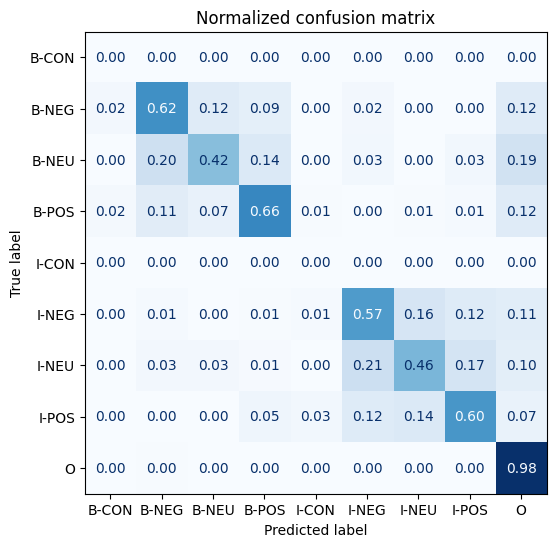

In [62]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      list(tag2index.keys()))


In [63]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df_validation["total_loss"] = df_validation["loss"].apply(sum)
df_tmp = df_validation.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample.T)
     

,tokens,labels,preds,losses
0,since,O,O,0.00
1,i,O,O,0.00
2,keyboard,O,O,0.28
3,over,O,O,0.00
4,100,O,O,0.00
5,w,O,O,0.00
6,##pm,IGN,O,-0.00
7,",",O,O,0.00
8,i,O,O,0.00
9,look,O,O,0.00


,tokens,labels,preds,losses
0,i,O,O,0.00
1,ca,O,O,0.00
2,n,O,O,0.00
3,',IGN,O,-0.00
4,t,IGN,O,-0.00
5,say,O,O,0.00
6,enough,O,O,0.00
7,of,O,O,0.00
8,how,O,O,0.00
9,satisfied,O,O,0.00


,tokens,labels,preds,losses
0,-,B-NEU,O,8.94
1,blue,IGN,B-POS,-0.00
2,##tooth,IGN,I-POS,-0.00
3,(,O,O,0.05
4,2,O,O,0.00
...,...,...,...,...
68,on,O,O,0.00
69,and,O,O,0.00
70,on,O,O,0.00
71,.,O,O,0.00


Errors could be from human / annotation errors: United Nations is ORG, not PER, similar to Central African Republic. This can happen as data was annotated using rule based, it is better with human annotations, but mistakes can always occur.

In [64]:

# hide_output
df_tmp = df_validation.loc[df_validation["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample.T)

# 4. <a id='toc4_'></a>[Save model](#toc0_)

In [65]:
# distilbert_tokenizer.save_pretrained('tokenizer/xlmr_tokenizer')

In [66]:
trainer.save_model('model/distilbert-base-uncased-absa')


# 5. <a id='toc5_'></a>[Load saved model](#toc0_)

In [67]:
from transformers import AutoModelForTokenClassification

# Reload the model
loaded_model = AutoModelForTokenClassification.from_pretrained('model/distilbert-base-uncased-absa').to(device) #output_model_dir
loaded_tokenizer = AutoTokenizer.from_pretrained('model/distilbert-base-uncased-absa')


In [68]:
num = 99
sample_input = df_train.iloc[num]['text']
print(sample_input)
print(df_train.iloc[num]['aspects'])

i also love having the extra calculator number set up on the keyboard which most laptops do not have.
[{'term': 'keyboard', 'polarity': 'positive', 'from': '61', 'to': '69'}]


In [69]:
# Assuming you have some input data
input_data = [sample_input]
# input_token_span = [list(TreebankWordTokenizer().span_tokenize(x)) for x in input_data]
# input_tokens = [[input_data[r][k[0]:k[1]] for k in row] for r, row in enumerate(input_token_span)]

# Tokenize and get predictions
inputs = loaded_tokenizer(input_data, is_split_into_words=True, return_tensors="pt")

# features = [dict(zip(inputs, t)) for t in zip(*inputs.values())]


input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# Make predictions
# with torch.no_grad():
outputs = loaded_model(input_ids, attention_mask)

predicted_label_idx = torch.argmax(outputs.logits, axis=-1).cpu().numpy()
df_res = pd.DataFrame({'predicted_label': predicted_label_idx.tolist(), 
                      'input_ids': inputs['input_ids'].numpy().tolist()}
                      )

In [70]:
index2tag_new = loaded_model.config.id2label.copy()
index2tag_new[-100] = "IGN"
df_res["input_tokens"] = df_res["input_ids"].apply(
    lambda x: loaded_tokenizer.convert_ids_to_tokens(x))
df_res["predicted_label_text"] = df_res["predicted_label"].apply(
    lambda x: [index2tag_new[i] for i in x])
df_res['predicted_label'] = df_res.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df_res['predicted_label_text'] = df_res.apply(
    lambda x: x['predicted_label_text'][:len(x['input_ids'])], axis=1)

df_res_tokens = df_res.apply(pd.Series.explode)
# df_tokens = df_tokens.query("labels != 'IGN'")
# df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
# # df_tokens.head(7)
df_res_tokens

,predicted_label,input_ids,input_tokens,predicted_label_text
0,8,101,[CLS],O
0,8,1045,i,O
0,8,2036,also,O
0,8,2293,love,O
0,8,2383,having,O
0,8,1996,the,O
0,8,4469,extra,O
0,8,10250,cal,O
0,8,19879,##cula,O
0,8,4263,##tor,O


In [72]:
from transformers import pipeline

token_classifier = pipeline(
    "token-classification", model=loaded_model, tokenizer=loaded_tokenizer, aggregation_strategy="simple"
)
token_classifier(sample_input)